In [27]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import curve_fit

sns.set_style('whitegrid')
%config InlineBackend.figure_formats = ['svg']

# Curve Fitting

Consider a situation where a variable of interest roughly follows some functional form, or seems to be based on an inherent "curve". In this case, there may be a feature-target relationship, or it might just be the target-over-time. Either way, a traditional machine learning model might not be appropriate, and instead we may simply want to model the data by fitting an explicit equation which can be used later. Here, we'll generate some data to illustrate a possible solution.

[SciPy](https://docs.scipy.org/doc/scipy/tutorial/index.html) is a collection of mathematical algorithms and convenience functions built on NumPy, and we're going to use it here to illustrate curve fitting.

## Latent Function

Given a predefined function `func` or $f$, and some range of $x$ values $x_i$ in `x_range`, we will generate an array of numbers $y_i$ which can be modeled by the following equation:

$$
y_i = f(x_i) + \epsilon
$$

where $\epsilon$ is some random value between $-p$ and $p$, if we set $p$ to be the "perturbation", or *deviation* from the expected value $f(x)$. In this way, our function $f$ is actually meant to represent an example of some **latent** (unknown) function that is driving some data we might observe in practice. In other words, we should pretend as if we do not know what $f$ is for this illustration of curve fitting.

In [28]:
def func_to_data(func, x_range=(-100, 100), perturb=1, n=100):
    '''
    Given a function, get data (or plot) for that function between `x_range`
    
    `perturb` is the amount of random jitter to add to function values.
    '''
    x_ = np.linspace(x_range[0], x_range[1], n)
    y_ = func(x_)
    w = np.mean(abs(y_))
    noise = np.random.uniform(-perturb * w, perturb * w, n)
    
    return (x_, y_ + noise)

### Polynomial Fit

A polynomial is of the form:

$$
f(x) = a_kx^k + a_{k-1}x^{k-1} + \cdots + a_1x + a_0
$$

Where $k$ represents the degree. We can define this in a function (as it will be expected from SciPy), with `x` as the first argument, and the coefficients as the following arguments. We'll use[ NumPy's `polyval`](https://numpy.org/doc/stable/reference/generated/numpy.polyval.html) to do the polynomial computation.

In [29]:
# general polynomial form for degree 3
def poly3(x, a_3, a_2, a_1, a_0):
    coeffs = np.array([a_3, a_2, a_1, a_0])
    return np.polyval(coeffs, x)

Suppose we create some data which is based on an underlying polynomial of degree 3 which we "do not know."

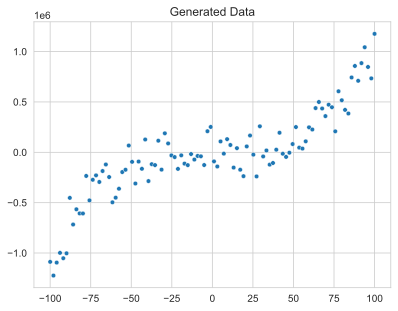

In [30]:
# pretend we do not know this ...
f_poly = lambda x: x ** 3 - 3 * x ** 2

x, y = func_to_data(f_poly)

g = sns.scatterplot(x=x, y=y, s=20)
g.set_title("Generated Data");

Now, we use the `curve_fit` function to fit to this data using our function definition `poly3` for which we need to find coefficients. *Note, setting `bounds` speeds up the calculation, and typically improves accuracy.*

In [31]:
# optimal coefficients and their covariance matrix
popt, pcov = curve_fit(poly3, x, y, bounds=(-100, 100))
popt

array([   1.09386751,   -3.29079541, -100.        , -100.        ])

This is not *exactly* right, but it's close enough.

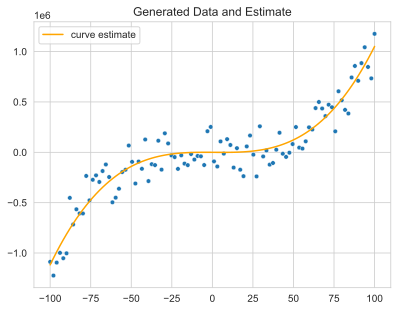

In [32]:
y_pred = np.polyval(popt, x)

g = sns.scatterplot(x=x, y=y, s=20)
g = sns.lineplot(x=x, y=y_pred, label='curve estimate', color='orange')

g.set_title("Generated Data and Estimate");

### Exponential Fit

A general form for the exponential function is:

$$
f(x) = ae^{bx}
$$
 
With coefficients $a$ and $b$.

In [33]:
# general exponential
def exp1(x, a, b):
    return a * np.exp(b * x)

Suppose we create some data which is based on an underlying polynomial of degree 3 which we "do not know."

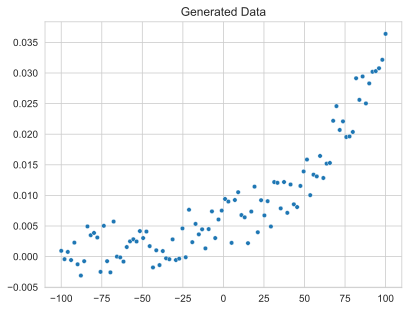

In [34]:
# pretend we do not know this ...
f_exp = lambda x: 0.005 * np.exp(0.02 * x)

x, y = func_to_data(f_exp, perturb=0.5)

g = sns.scatterplot(x=x, y=y, s=20)
g.set_title("Generated Data");

In [35]:
# optimal coefficients and their covariance matrix
popt, pcov = curve_fit(exp1, x, y, bounds=(-100, 100))
popt

array([0.00481729, 0.01974296])

This is fairly close!

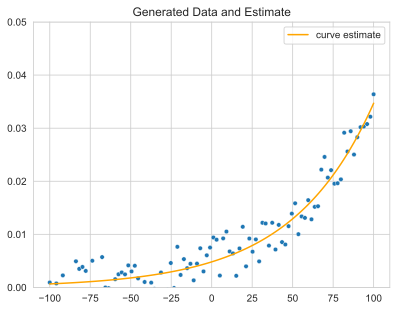

In [36]:
y_pred = popt[0] * np.exp(popt[1] * x)

g = sns.scatterplot(x=x, y=y, s=20)
g = sns.lineplot(x=x, y=y_pred, label='curve estimate', color='orange')

g.set_ylim(0, 0.05)
g.set_title("Generated Data and Estimate");

# Time Series

For the remainder of the lab, you'll need to install the following **using conda**:
- Plotly
    - (in your `base` environment, or wherever you call `jupyter lab`) follow *both* the [plotly](https://plotly.com/python/getting-started/#installation) steps and the [jupyter support](https://plotly.com/python/getting-started/#jupyterlab-support) steps.
    - (in the environment running this notebook) Just follow the main "plotly" instructions.
- [Prophet](https://facebook.github.io/prophet/docs/installation.html#installation-in-python)

To illustrate some of the [**time series functionality of pandas**](https://pandas.pydata.org/docs/user_guide/timeseries.html) (and plotly), we'll use a [dataset](https://github.com/facebook/prophet/blob/main/docs/_docs/quick_start.md#python-api) which contains an approximate **log** of the daily page views of the Peyton Manning page. So, if $y = 8.321$ then the number of page views is $\approx e^{8.321}$.

In [37]:
import pandas as pd
import plotly.express as px

In [38]:
# The number of daily hits on Peyton Manning's Wikipedia page for a few years
df_manning = pd.read_csv('./data/manning.csv')

In [39]:
df_manning.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [40]:
df_manning.rename(columns={'ds': 'date',
                           'y': 'hits'},
                  inplace=True)

In [41]:
# Make sure we don't have duplicate dates
df_manning.date.duplicated().sum()

0

## Recognizing Time Series

There are three main components of any time series:

- **Trend:** The *overall* increasing or decreasing
- **Season:** Patterns which repeat indefinitely
    - There can be multiple seasons in a time series
- **Residual:** Noise resulting from natural processes

We define each row of the time series as a **period**. That is, moving from row 1 at time $t=1$ to row 2 at time $t=2$ is equivalent to completing one period. We say that the **frequency** of the time series is the number of periods per "cycle". So, if our data has a weekly cycle, and a daily period, our frequency is 7. Typically, we can think of things happening according to some repeating schedule (e.g., weekly classes, etc.), but it is also possible for the frequency to be equal to 1 in the case where there isn't really a define schedule or cycle.

In [42]:
# This will make future operations easier
df_manning['date'] = pd.to_datetime(df_manning['date'])
df_manning.set_index('date', inplace=True)
df_manning.sort_index(inplace=True)

In [43]:
px.line(df_manning, template='simple_white')

## Differencing

A **lag** is a previous period. In particular, $\text{lag} = k$ is $k$ periods "ago". We can use `shift` to create columns of data that contain previous lags, and of course you can do analysis on these data as well.

In [44]:
# a positive number is "in the past"
df_manning['hits_last_week'] = df_manning.shift(7)

In [45]:
df_manning['hits_weekly_delta'] = (df_manning['hits'] - 
                                   df_manning['hits_last_week'])

In [46]:
df_manning['hits_weekly_delta'].describe()

count    2898.000000
mean        0.001045
std         0.597610
min        -4.428490
25%        -0.222085
50%        -0.008786
75%         0.233395
max         3.524829
Name: hits_weekly_delta, dtype: float64

# Smoothing

Time series data is often very difficult to read, especially with highly periodic data. One of the first things we can do to make time series look clearer is "smooth" the data by incrementally consolidating multiple datapoints in windows. In general, when we apply smoothing, we assign each data point a moving window called a **filter**. For each filter, we aggregate some value (such as the mean) of the data within the filter, then we replace each datapoint with the newly calculated value. It helps us detect patterns and capture trends that might otherwise go unnoticed.

In [47]:
mask = df_manning.index.year == 2014

fig = px.line(df_manning[mask]['hits'], template='simple_white')

fig.add_vrect(x0="2014-02-01", x1="2014-04-01", 
              annotation_text="filter", annotation_position="top right",
              fillcolor="orange", opacity=0.25, line_width=0)

fig.add_vline(x='2014-03-01', line_color='red', line_width=1, opacity=1)
fig

## Rolling Average

With a rolling average, our aggregate value is the average, and we can choose the window size to be a particular number of days (for example). Here, we use `.rolling` in pandas to select a *rolling* window size of width **30 days**.

In [48]:
df_plot = df_manning.copy()
df_plot['rolling'] = df_plot.hits.rolling(30).mean()

px.line(df_plot[['hits', 'rolling']], template='simple_white', height=200)

Alternatively, we could select a *static* [offset in pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases) based on the calendar. Here we'll choose weekly `W`, and the end of the month `'ME'` (for **m**onth **e**nd), and assign our calculation (i.e., the mean) to each "end of the month".

In [49]:
# With datetime index, we can "resample" a rolling average by week and month
df_manning_ = df_manning.reset_index()
df_manning_['window'] = 'original'

df_manning_weekly = df_manning.hits.resample('W').mean().reset_index()
df_manning_weekly['window'] = 'week'

df_manning_monthly = df_manning.hits.resample('ME').mean().reset_index()
df_manning_monthly['window'] = 'month'

df_plot = pd.concat([df_manning_, df_manning_weekly, df_manning_monthly])

ValueError: Invalid frequency: ME

In [ ]:
px.line(df_plot, x='date', y='hits', facet_row='window', template='simple_white', height=700)

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['hits', 'hits_last_week', 'hits_weekly_delta', 'rolling'] but received: date

Using the rolling average, we can start to see how weekly and monthly seasons are apparent in our data.

## LO(W)ESS Smoothing

Locally Weighted Scatterplot Smoothing or Locally Estimated Scatterplot Smoothing fits a *weighted* linear model for the data within each window, weighing points by their distance from the center. The resulting curve is one which retains the slope of each of the fit lines at each point.

*Note: In fact, this is just one of [many smoothing methods in Plotly](https://plotly.com/python/linear-fits/), including the rolling average.*

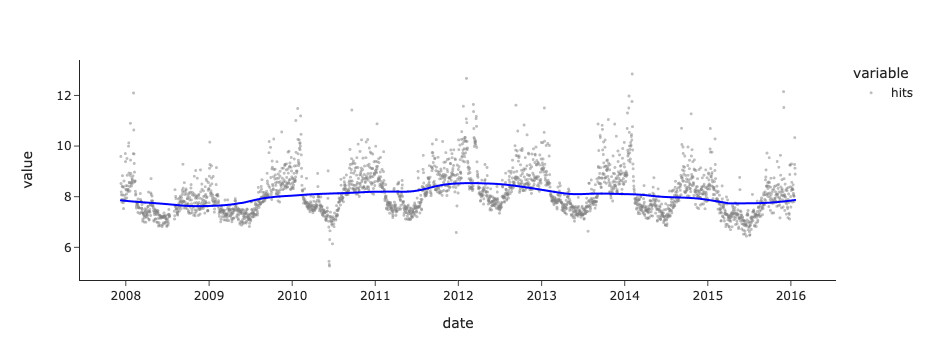

In [ ]:
g = px.scatter(df_manning['hits'], template='simple_white', opacity=0.5, color_discrete_sequence=['gray'],
               trendline="lowess", trendline_color_override='blue',
               trendline_options=dict(frac=0.2))  # adjust the window here

g.update_traces(marker={'size': 3})
g.update_layout()

## Interpolation

This makes a lot more sense if we are missing some values ...

In [ ]:
# take the small subset of data at the beginning of 2016
df_manning_sample = df_manning[df_manning.index.year >= 2016]

# Suppose we're missing some data
df_missing = df_manning_sample['hits'].sample(frac=0.5)

df_missing.sort_index().head()

date
2016-01-01    7.589336
2016-01-02    7.825245
2016-01-04    9.295141
2016-01-05    8.568266
2016-01-06    8.352554
Name: hits, dtype: float64

In [ ]:
# Fill missing days with NAN
df_missing = df_missing.resample('D').mean()

df_missing.head()

date
2016-01-01    7.589336
2016-01-02    7.825245
2016-01-03         NaN
2016-01-04    9.295141
2016-01-05    8.568266
Freq: D, Name: hits, dtype: float64

In [ ]:
# interpolate the missing values
df_interp = df_missing.interpolate(method='linear')  # Try 'cubic'

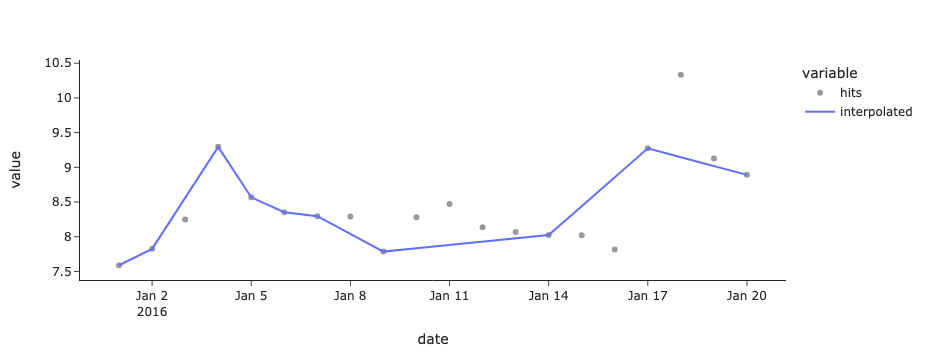

In [ ]:
gaps = px.scatter(df_manning_sample['hits'], template='simple_white', opacity=0.8, 
                  color_discrete_sequence=['gray', 'pink'])

interp = px.line(df_interp).data[0]
interp.name = 'interpolated'

gaps.add_trace(interp)

All the (missing) pink points would be replaced by the values on the blue line.

# Facebook Prophet

*This walkthrough is a slightly more in depth rendition of the [tutorial](https://facebook.github.io/prophet/docs/quick_start.html) on Facebook Prophet's documentation.*

Prophet is specifically designed for natural time series, i.e., where words like “weekly”, “quarterly”, and “annually” make sense. In particular:

- Holidays are a major factor in how the trend progresses
- Trends are not constant, i.e., they may shift
- Prophet may not perform well in non-traditional settings
    - E.g., image a series based on lifetime events of an amoeba or bacteria

In [50]:
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

c:\Users\rushy\miniconda3\envs\i501_first\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



*Note: If you see a TqdmWwarning regarding jupyter and ipywidgets, it's okay to ignore it if you're running JupyterLab 3.*

## Data

In [51]:
# This is the same data as above, but we need it in its raw form now
df = pd.read_csv('./data/manning.csv')
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [ ]:
df.shape

(2905, 2)

In [ ]:
px.line(df.set_index('ds'), template='simple_white')

This DataFrame is formatted especially for Facebook Prophet. I.e., **the input for a Prophet model is always a Pandas DataFrame with two columns: `ds` (datestamp), and `y` (the series).** To incorporate more (exogenous) features into your model, you need to either ensemble multiple models (a topic we'll discuss in a later module). Either way, time is usually more than sufficient to model a univariate time series (like the one above). Any more features will only incrementally improve the model, but it will also complicate interpretation.

*Note: We'll continue to also use the `df_manning` data frame from above for plotting, since they are formatted slightly differently for different reasons.*

## Components

Prophet is a variant of the [Generalized Additive Model (GAM)](https://en.wikipedia.org/wiki/Generalized_additive_model). In this case, **time is the only regressor** (or, feature), but it is applied through 3 functions:

$$
y(t) = g(t) + s(t) + h(t) + \varepsilon(t)
$$

Where:
- $y(t)$ is the value of the time series at time $t$
- $g(t)$ is the **trend** contribution at time $t$
- $s(t)$ is the **seasonality** contribution at time $t$
- $h(t)$ is the **holiday** effect at time $t$
- $\varepsilon(t)$ is random noise, estimated for time $t$

According to the Prophet team: *"We are, in effect, framing the forecasting problem as a curve-fitting exercise, which is inherently different from time series models that explicitly account for the temporal dependence structure in the data."*

Here, we'll illustrate the typical Prophet model workflow by using default parameters. **If you plan to tailor the model further to your use case, refer to the [Prophet documentation](https://facebook.github.io/prophet/docs/quick_start.html).** It is very accessible, and highly recommended.

### Trend

In Prophet, **trend** is modeled as a piecewise linear function, broken up by “change points” where the slope of the trend line changes. For example, we can use LOWESS to visualize the slight change in trend in our Peyton Manning data.

In [ ]:
g = px.scatter(df_manning['hits'], template='simple_white', opacity=0.5, color_discrete_sequence=['gray'],
               trendline="lowess", trendline_options=dict(frac=1), trendline_color_override='blue')

g.add_vline(x='2012-01-01', line_width=2, line_color="darkorange", line_dash='dot', opacity=1)

g.update_traces(marker={'size': 3})
g.update_layout()

The orange line here would represent a "change point", and to the left side of the orange line would have one trend function, and the right would have another.

- Change points may be obvious
- By default, the Prophet model infers their frequency using a [Laplacian](https://en.wikipedia.org/wiki/Laplace_distribution) prior distribution with parameter $\tau$ and mean of 0.
    - As $\tau$ goes to zero, we get fewer change points (more like a linear model)
    - As $\tau$ increases, we allow for more change points (can get unstable …)
    - In practice, $\tau$ is represented as `changepoint_prior_scale`
- We can also define these manually (e.g., product launches, etc.)

### Seasonality

- Fourier transformations capture seasons within a period
- Prophet aims to capture only the low (common) frequency seasons
    - We can adjust this (e.g., `monthly_seaonality=10`)
    - Smaller `_seaonality` values translate to smoother seasonal model
- Each season gets a random (smoothed) weight
- Decreasing `seasonality_prior_scale` translates to smoother seasonality

### Holidays

- Holidays are very irregular, so they are captured as **dummy variables**
- Prophet accepts a DataFrame of holidays, each with different dates
    - The day(s) after a holiday may also be defined as holidays
    - The effect to the model may be different for different holidays
- A la seasons, holidays will get random weight in the model
    - Decreasing `holiday_prior_scale` translates to a smoother holiday model

## Modeling

In [ ]:
model = Prophet(daily_seasonality=True)  # use Shift+Tab in the parentheses to peek the below info

In [ ]:
# What options does Prophet provide? 
?Prophet

Init signature:
Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=25,
    changepoint_range=0.8,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
    scaling: str = 'absmax',
    holidays_mode=None,
)
Docstring:     
Prophet forecaster.

Parameters
----------
growth: String 'linear', 'logistic' or 'flat' to specify a linear, logistic or
    flat trend.
changepoints: List of dates at which to include potential changepoints. If
    not specified, potential changepoints are selected automatically.
n_changepoints: Number of potential changepoints to include. Not used
    if input `changepoints` is supplied. If `changepoints` is not supplied,
    then n_changepoints potential changep

In [ ]:
model.fit(df)

22:04:39 - cmdstanpy - INFO - Chain [1] start processing
22:04:41 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# select the number of periods (in this case, days) to forecast
df_future = model.make_future_dataframe(periods=365)
df_future.shape

(3270, 1)

In [ ]:
type(df_future)

pandas.core.frame.DataFrame

In [ ]:
df_future.shape[0] - df.shape[0]

365

In [ ]:
df_future.head()

,ds
0,2007-12-10
1,2007-12-11
2,2007-12-12
3,2007-12-13
4,2007-12-14


`df_future` stores the dates for which we can forecast. We now use the model to make predictions for these days.

In [ ]:
df_forecast = model.predict(df_future)

In [ ]:
df_forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

`df_forecast` is essentially a decomposition of our original trend and forecast, through Prophet. We can use this DataFrame to plot (and evaluate) the forecast.

In [ ]:
fig = plot_plotly(model, df_forecast, figsize=(800, 600))
fig.update_layout(template='simple_white')

Second, we can plot a decomposition of this trend by plotting the `components`.

In [ ]:
fig = plot_components_plotly(model, df_forecast, figsize=(800, 200))
fig.update_layout(template='simple_white')

We can use this plot to make changes to the original model if you like. E.g., maybe you want to reduce the number of trend change points by updating `n_changepoints` or the `changepoint_prior_scale`.

### A Few Notes on Forecasts

Forecasts are generated by sampling past trend shifts from the calculated change points (i.e., trend shifts). This simulates what future trend shifts might occur. In other words,

**We assume *"the future will see the same average frequency and magnitude of rate changes that were seen [in history]."*** 

This is a pretty biased assumption, so:

* Uncertainty intervals will not exactly match reality
* This can help us evaluate overfitting (over time)
* Higher `changepoint_prior_scale` means higher flexibility in fitting, **but**
* Higher `changepoint_prior_scale` *also* means wider uncertainty regions and more overfitting

The further into the future you go, the more uncertainty there is in the trend change, so you can expect a wider region of unknown trend (from the distribution of trends seen). **The uncertainty regions are not confidence intervals.** The only way they would be is if the model were perfectly specified, but this can only be estimated with a bound which is affected by the fact that errors are not independent and identically distributed (i.i.d., as assumed).

## Saving and Loading Prophet Models

We can save Python models using JSON [serialization](https://learnpython.com/blog/object-serialization-in-python/).

In [ ]:
from prophet.serialize import model_to_json, model_from_json

with open('./model.json', 'w') as f:
    f.write(model_to_json(model))  # Save model

# with open('serialized_model.json', 'r') as f:
#     m = model_from_json(f.read())  # Load model

# EXERCISES

## Exercise 1

Using the examples at the begining of this lab, generate some data that follows a logarithmic pattern, then plot the generated data. Fit a curve to this data using `curve_fit`.

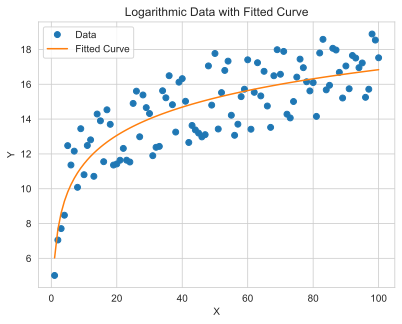

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


def logarithmic_func(x, a, b):
  return a * np.log(x) + b

x = np.linspace(1, 100, 100)  

# Generate logarithmic data with some noise
y = logarithmic_func(x, 2, 5) + np.random.rand(100) * 5

popt, pcov = curve_fit(logarithmic_func, x, y)
a_fitted, b_fitted = popt
y_fitted = logarithmic_func(x, a_fitted, b_fitted)

plt.plot(x, y, 'o', label='Data')
plt.plot(x, y_fitted, '-', label='Fitted Curve')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Logarithmic Data with Fitted Curve')
plt.legend()
plt.grid(True)
plt.show()




## Exercise 2

Take a look at the Prophet documentation for [changepoints](https://facebook.github.io/prophet/docs/trend_changepoints.html) or for [seasonality](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html). Based on what you see, pick 2-3 hyperparameters of the `model = Prophet(...)` instantiation to make adjustments to. Try *extremely* different values, and write a few sentences about what the changes do to the model (i.e., for each hyperparameter change, hold the others constant).

In [53]:
df = pd.read_csv('./data/manning.csv')
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [54]:
model = Prophet()

In [55]:
model_changepoint = Prophet(changepoint_prior_scale=0.7) 
model_changepoint.fit(df)

16:41:05 - cmdstanpy - INFO - Chain [1] start processing
16:41:06 - cmdstanpy - INFO - Chain [1] done processing


A higher value makes the changepoints more flexible and allows them to adapt to the data more closely.


In [56]:
model_seasonality = Prophet(seasonality_prior_scale=14.0)  # Adjust seasonality_prior_scale
model_seasonality.fit(df)

16:41:20 - cmdstanpy - INFO - Chain [1] start processing
16:41:20 - cmdstanpy - INFO - Chain [1] done processing


A higher value allows the model to fit the observed seasonality more closely, potentially capturing shorter-term fluctuations. Conversely, a lower value imposes more conservative assumptions about the seasonality.
By setting it to 14.0,we are indicating a relatively high strength of seasonality in the model.

In [57]:
model_holidays = Prophet(holidays_prior_scale=0.02)  # Adjust holidays_prior_scale
model_holidays.fit(df)

16:41:34 - cmdstanpy - INFO - Chain [1] start processing
16:41:34 - cmdstanpy - INFO - Chain [1] done processing


This parameter determines the strength of the prior distribution for the holiday effects.
Setting holidays_prior_scale to 0.02 indicates a relatively low strength of the prior distribution for holiday effects. This suggests that we are assuming a conservative influence of holidays on the time series.